# Deep Q-Learning for Portfolio Optimization with PyTorch

## Introduction  
Portfolio optimization involves allocating wealth across assets (e.g., stocks and bonds) to balance return and risk. Traditional methods like Markowitz mean-variance optimization require predicting returns and covariances, which is challenging in practice. Instead, we can use **Deep Reinforcement Learning (DRL)** to directly learn portfolio allocation strategies by interacting with market data, without explicitly forecasting future prices. In this notebook, we implement a **Deep Q-Learning (DQL)** agent in PyTorch to manage a portfolio of 3 assets. The agent observes market states and adjusts asset weights, with the goal of maximizing a reward signal (e.g. portfolio growth or risk-adjusted return). The following will also be discussed in this notebook:  

- **State Representation:** Constructing state features (prices, technical indicators, returns, volatility).  
- **Action Space:** Defining portfolio weight adjustment actions for 3 assets (weights summing to 1).  
- **Reward Functions:** Experimenting with multiple reward definitions – portfolio value growth, Sharpe ratio, and drawdown-based rewards.  
- **Dataset:** Using a public historical market dataset for training and evaluation.  
- **Implementation:** Building the DQL agent with PyTorch, including data preprocessing, feature engineering, model training, and evaluation.  

## 1. State Representation  
The **state** should capture relevant information about the market and portfolio at each time step. We include:  

- **Prices:** Recent prices of stocks (e.g. daily close prices).  
- **Technical Indicators:** Features derived from price history, such as moving averages, Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), Bollinger Bands, etc. These are commonly used to gauge trends and momentum.  
- **Historical Returns:** Recent returns (e.g. daily or weekly percentage changes) for each asset, providing momentum or reversal signals.  
- **Volatility:** Measures of risk such as rolling standard deviation of returns (e.g. 1-month volatility) for each asset.  

We compute these indicators using pandas and numpy.



In [23]:
import yfinance as yf
import pandas as pd
import numpy as np

# Step 1: Download data using yfinance
tickers = ['AAPL', 'MSFT', 'GOOGL']
data = yf.download(tickers, start="2015-01-01", end="2023-01-01")
close_prices = data['Close'].dropna()

# Step 2: Use original price data as in the notebook
price_data = close_prices.copy()

# Step 3: Calculate technical indicators
window_ma = 20
price_data_ma = price_data.rolling(window_ma).mean().add_suffix(f'_{window_ma}dma')

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(period).mean()
    loss = -delta.clip(upper=0).rolling(period).mean()
    RS = gain / (loss + 1e-9)
    return 100 - (100 / (1 + RS))

rsi_df = price_data.apply(compute_rsi, period=14).add_suffix('_rsi')

def compute_macd(series, span_short=12, span_long=26, span_signal=9):
    ema_short = series.ewm(span=span_short, adjust=False).mean()
    ema_long = series.ewm(span=span_long, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=span_signal, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

macd_lines = {}
for col in price_data.columns:
    macd_line, _, _ = compute_macd(price_data[col])
    macd_lines[col + '_macd'] = macd_line
macd_df = pd.DataFrame(macd_lines)

returns_1d = price_data.pct_change(1).add_suffix('_ret1')
returns_5d = price_data.pct_change(5).add_suffix('_ret5')
vol_21d = price_data.pct_change().rolling(21).std().add_suffix('_vol21')

# Step 4: Combine all features into one DataFrame
state_features_df = pd.concat([price_data, price_data_ma, rsi_df, macd_df, returns_1d, returns_5d, vol_21d], axis=1)
state_features_df = state_features_df.dropna()

# Preview
state_features_df.head()
state_features_df.shape




[*********************100%***********************]  3 of 3 completed


(1993, 21)

In the code above, the **S&P 500 stock data (5-year daily prices for S&P 500 companies)** is loaded from yahoo finance and 3 assets are chosen. We have to ensure to split the data into a **training period** and a **testing period** for evaluation. After computing features, each state at time *t* can be represented as a concatenation of the features for all 3 assets (and any portfolio-specific info). For instance, our `state_features_df` now contains columns like `Asset1` price, `Asset1_20dma`, `Asset1_rsi`, `Asset1_macd`, ..., `Asset1_ret1`, ..., `Asset1_vol21`, and similarly for `Asset2`, ..., `Asset3`. At a given date (row), those values form the state vector. We will feed this state vector into the DQL agent’s neural network.


## 2. Action Space  
The agent’s **action** is to adjust the portfolio weights of the 3 assets. We constrain weights to be between 0 and 1 and sum to 1 (fully invested, no shorting or leverage). This is inherently a continuous action space, but we discretize it by defining a finite set of possible portfolio adjustments. We define actions as shifting a fixed percentage (e.g., 10%) from one asset to another while keeping weights valid.


In [2]:
import numpy as np
from itertools import product

def generate_allocations(num_assets, step=0.05):
    levels = int(1 / step)  # e.g., 0.05 -> 20 levels
    grid = np.arange(0, 1 + step, step)
    allocations = []

    for weights in product(grid, repeat=num_assets):
        if np.isclose(sum(weights), 1.0):
            allocations.append(np.round(weights, 2))

    return np.array(allocations)

# Example: 3 assets
allocations = generate_allocations(num_assets=3, step=0.05)
print(f"Generated {len(allocations)} allocations")
action_space = generate_allocations(num_assets=3, step=0.05)
print(allocations[:5])  # Show first few

Generated 231 allocations
[[0.   0.   1.  ]
 [0.   0.05 0.95]
 [0.   0.1  0.9 ]
 [0.   0.15 0.85]
 [0.   0.2  0.8 ]]


## 3. Reward Function  
The **reward function** drives the agent’s behavior. We experiment with multiple reward definitions:

- **Portfolio Value Growth:** Reward = change in portfolio value (e.g., portfolio return from one step to the next). This directly incentivizes the agent to increase the portfolio’s wealth. We can use the **daily return** (percentage change in portfolio value) as the reward at each step. Alternatively, using the log return $ \log(V_{t+1} / V_t) $ can stabilize training since log returns add linearly over time.

- **Sharpe Ratio Approximation:** The Sharpe ratio measures return per unit of risk. Since the full Sharpe ratio requires a long period to calculate, we use an approximation:  
  $
  \text{Reward} = \text{return}_t - 0.5 \times (\text{return}_t)^2
  $
  This encourages the agent to maximize returns while minimizing high variance, which indirectly improves risk-adjusted returns.

- **Drawdown Minimization:** Drawdown is the decline from the historical peak portfolio value. We penalize the agent when the portfolio value drops. One approach is:  
$
  \text{Reward}_t = \text{return}_t - \alpha \times \max(0, (\text{max\_value\_so\_far} - \text{current\_value}) / \text{max\_value\_so\_far})
  $
  where $ \alpha $ is a penalty factor. This means if a new drawdown occurs, the reward is reduced. The agent is thus encouraged to avoid large drawdowns.


In [3]:
# Define reward calculation functions for different reward modes

def reward_growth(portfolio_return):
    """
    Reward equals raw portfolio return (increase in value) for the step.
    """
    return portfolio_return  # (this could be percentage or log-return; we'll use simple percentage)

def reward_sharpe_approx(portfolio_return):
    """
    Reward approximating Sharpe: return minus penalty for volatility.
    Using return - 0.5*return^2 as a simple proxy (the quadratic term penalizes large deviations).
    """
    return portfolio_return - 0.5 * (portfolio_return ** 2)

def reward_drawdown(portfolio_return):
    """
    Reward that strongly penalizes negative returns (to avoid drawdowns).
    For example, give full credit for positive return, but 2x penalty for negative.
    """
    if portfolio_return >= 0:
        return portfolio_return
    else:
        return portfolio_return * 2  # negative reward doubled in magnitude for losses


## 4. Dataset and Environment Setup  
We use a public dataset of historical stock and bond prices. The environment simulates portfolio management, allowing the agent to observe states, take actions, and receive rewards. We define a `PortfolioEnv` class that handles state updates and reward calculation.


In [4]:
class PortfolioEnv:
    def __init__(self, feature_df, price_df, action_space, reward_mode="growth"):
        """
        feature_df: DataFrame of state features (index is dates, columns are features for all assets)
        price_df: DataFrame of prices (to compute returns)
        action_space: list of possible weight vectors (numpy arrays)
        reward_mode: "growth", "sharpe", or "drawdown" to select reward function
        """
        self.feature_df = feature_df
        self.price_df = price_df
        self.dates = feature_df.index
        self.n_steps = len(self.dates)
        self.action_space = action_space
        self.reward_mode = reward_mode
        # Map mode to reward function
        self.reward_func = {
            "growth": reward_growth,
            "sharpe": reward_sharpe_approx,
            "drawdown": reward_drawdown
        }[reward_mode]
        self.reset()
    
    def reset(self):
        """Reset environment to beginning of data. Returns initial state."""
        self.current_step = 0
        self.portfolio_value = 1.0
        # Start with equal weights
        self.current_weights = np.array([1.0/asset_count]*asset_count)
        # Get initial state (features at current_step index)
        state = self.feature_df.iloc[self.current_step].values.astype(np.float32)
        self.max_portfolio_value = self.portfolio_value  # track peak for drawdown if needed
        return state
    
    def step(self, action_idx):
        """
        Execute the action given by index in the action space.
        Returns: next_state, reward, done (bool)
        """
        # Get weight vector for the action
        new_weights = self.action_space[action_idx]
        # Compute portfolio return from current_step to next_step using current weights (before rebalancing)
        # We assume the action (new_weights) is applied at current_step (after observing state),
        # and the return realized over next interval is based on these new weights.
        # We can use price_df to compute returns
        if self.current_step >= self.n_steps - 1:
            # no next step available
            return None, 0.0, True
        # Calculate asset returns from current_step to current_step+1
        current_prices = self.price_df.iloc[self.current_step]
        next_prices = self.price_df.iloc[self.current_step + 1]
        asset_returns = (next_prices.values - current_prices.values) / current_prices.values  # simple return
        portfolio_return = float(np.dot(new_weights, asset_returns))
        # Update portfolio value
        self.portfolio_value *= (1 + portfolio_return)
        # Update drawdown tracker
        if self.portfolio_value > self.max_portfolio_value:
            self.max_portfolio_value = self.portfolio_value
        # Compute reward using chosen reward function
        reward = self.reward_func(portfolio_return)
        # Move to next time step
        self.current_step += 1
        done = (self.current_step == self.n_steps - 1)  # episode ends at last available data point
        # Get next state
        if not done:
            next_state = self.feature_df.iloc[self.current_step].values.astype(np.float32)
        else:
            next_state = None
        # Update current weights to new_weights (assuming we rebalanced to new_weights at step)
        self.current_weights = new_weights.copy()
        return next_state, float(reward), done


In [17]:
# Splitting dataset into Train (80%) and Test (20%)
train_size = int(0.8 * len(state_features_df))
asset_count = 3

# Training Data
train_features = state_features_df.iloc[:train_size]
train_prices = price_data.iloc[:train_size]

# Testing Data
test_features = state_features_df.iloc[train_size:]
test_prices = price_data.iloc[train_size:]

# Define training and testing environments
train_env = PortfolioEnv(feature_df=train_features, price_df=train_prices, action_space=action_space, reward_mode="growth")
test_env = PortfolioEnv(feature_df=test_features, price_df=test_prices, action_space=action_space, reward_mode="growth")

train_env_sharp = PortfolioEnv(feature_df=train_features, price_df=train_prices, action_space=action_space, reward_mode="sharpe")
test_env_sharp = PortfolioEnv(feature_df=test_features, price_df=test_prices, action_space=action_space, reward_mode="sharpe")

train_env_draw = PortfolioEnv(feature_df=train_features, price_df=train_prices, action_space=action_space, reward_mode="drawdown")
test_env_draw = PortfolioEnv(feature_df=test_features, price_df=test_prices, action_space=action_space, reward_mode="drawdown")


print(f"Train Size: {len(train_features)}, Test Size: {len(test_features)}")

Train Size: 1594, Test Size: 399



## 5. Deep Q-Learning Agent Implementation (PyTorch)  
We implement a **DQL agent** with:

- A **Q-network** (neural network estimating Q-values for state-action pairs).
- **Experience Replay** (stores past transitions for training stability).
- **Target Network** (stable Q-value updates).
- **Epsilon-Greedy Exploration** (random exploration decaying over episodes).
- **Bellman Update** (optimizing Q-values using the Bellman equation).

The Bellman equation is given by:
$$
Q(s, a) = r + \gamma \max_{a'} Q(s', a')
$$
where:
<ul>
  <li>\( Q(s, a) \) is the Q-value for state \( s \) and action \( a \),</li>
  <li>\( r \) is the immediate reward received after taking action \( a \),</li>
  <li>\( \gamma \) is the discount factor.</li>
  <li>\( \max_{a'} Q(s', a') \) represents the maximum Q-value for the next state \( s' \).</li>
</ul>
Training involves running episodes where the agent interacts with the environment, stores experiences in a replay buffer, and updates the Q-network using mini-batch gradient descent.



In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Define the Q-network architecture
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        # A simple 3-layer feedforward network
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q_values = self.fc3(x)
        return q_values

# Replay memory to store past transitions
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        # Convert to torch tensors
        state = torch.tensor(state, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.int64)
        reward = torch.tensor(reward, dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        done = torch.tensor(done, dtype=torch.float32)
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)


In [12]:
import torch
import torch.nn.functional as F
from tqdm import trange

# Hyperparameters
num_episodes = 1000
gamma = 0.99
batch_size = 64
lr = 1e-4
target_update_freq = 10
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_steps = 5000
warmup_steps = 1000
max_grad_norm = 1.0

# Setup
state_dim = train_features.shape[1]
action_dim = len(action_space)

policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
memory = ReplayBuffer(capacity=10000)

# Schedulers
step_count = 0
epsilon = epsilon_start

# Tracking
episode_rewards = []
episode_losses = []

for ep in trange(num_episodes, desc="Training"):
    state = train_env.reset()
    total_reward = 0
    losses = []

    done = False
    while not done:
        step_count += 1

        # Epsilon decay
        epsilon = max(epsilon_end, epsilon_start - step_count / epsilon_decay_steps)

        # Action selection
        if random.random() < epsilon:
            action_idx = random.randrange(action_dim)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                q_values = policy_net(state_tensor)
                action_idx = q_values.argmax().item()

        next_state, reward, done = train_env.step(action_idx)
        total_reward += reward

        memory.push(state, action_idx, reward, next_state if next_state is not None else state, done)
        state = next_state

        # Only train after warmup
        if len(memory) > warmup_steps:
            states_b, actions_b, rewards_b, next_states_b, dones_b = memory.sample(batch_size)

            # Q(s,a)
            q_values = policy_net(states_b).gather(1, actions_b.view(-1, 1)).squeeze(1)

            # Double DQN: a' = argmax Q(s', a; policy_net), Q_target = Q(s', a'; target_net)
            with torch.no_grad():
                next_actions = policy_net(next_states_b).argmax(1)
                next_q_values = target_net(next_states_b).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                target_q = rewards_b + gamma * next_q_values * (1 - dones_b)

            loss = F.smooth_l1_loss(q_values, target_q)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_grad_norm)
            optimizer.step()

            losses.append(loss.item())

    episode_rewards.append(total_reward)
    episode_losses.append(np.mean(losses) if losses else 0)

    if (ep + 1) % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())


    # Print training progress every 10 episodes
    if ep % 10 == 0:
        print(f"Episode {ep}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

print("Training on train set complete.")


Training:   0%|                                                                       | 1/1000 [00:02<38:47,  2.33s/it]

Episode 0, Total Reward: 1.88, Epsilon: 0.68


Training:   1%|▋                                                                   | 11/1000 [01:02<1:39:44,  6.05s/it]

Episode 10, Total Reward: 2.06, Epsilon: 0.05


Training:   2%|█▍                                                                  | 21/1000 [02:02<1:36:39,  5.92s/it]

Episode 20, Total Reward: 2.12, Epsilon: 0.05


Training:   3%|██                                                                  | 31/1000 [03:02<1:36:08,  5.95s/it]

Episode 30, Total Reward: 1.75, Epsilon: 0.05


Training:   4%|██▊                                                                 | 41/1000 [04:02<1:36:08,  6.02s/it]

Episode 40, Total Reward: 2.00, Epsilon: 0.05


Training:   5%|███▍                                                                | 51/1000 [05:01<1:34:13,  5.96s/it]

Episode 50, Total Reward: 1.95, Epsilon: 0.05


Training:   6%|████▏                                                               | 61/1000 [06:03<1:36:59,  6.20s/it]

Episode 60, Total Reward: 2.20, Epsilon: 0.05


Training:   7%|████▊                                                               | 71/1000 [07:06<1:38:09,  6.34s/it]

Episode 70, Total Reward: 2.08, Epsilon: 0.05


Training:   8%|█████▌                                                              | 81/1000 [08:09<1:36:25,  6.30s/it]

Episode 80, Total Reward: 1.79, Epsilon: 0.05


Training:   9%|██████▏                                                             | 91/1000 [09:12<1:36:58,  6.40s/it]

Episode 90, Total Reward: 2.36, Epsilon: 0.05


Training:  10%|██████▊                                                            | 101/1000 [10:16<1:35:58,  6.41s/it]

Episode 100, Total Reward: 2.15, Epsilon: 0.05


Training:  11%|███████▍                                                           | 111/1000 [11:23<1:35:05,  6.42s/it]

Episode 110, Total Reward: 2.11, Epsilon: 0.05


Training:  12%|████████                                                           | 121/1000 [12:26<1:32:30,  6.31s/it]

Episode 120, Total Reward: 2.21, Epsilon: 0.05


Training:  13%|████████▊                                                          | 131/1000 [13:30<1:32:14,  6.37s/it]

Episode 130, Total Reward: 2.35, Epsilon: 0.05


Training:  14%|█████████▍                                                         | 141/1000 [14:34<1:31:56,  6.42s/it]

Episode 140, Total Reward: 2.09, Epsilon: 0.05


Training:  15%|██████████                                                         | 151/1000 [15:37<1:29:35,  6.33s/it]

Episode 150, Total Reward: 1.98, Epsilon: 0.05


Training:  16%|██████████▊                                                        | 161/1000 [16:41<1:28:39,  6.34s/it]

Episode 160, Total Reward: 2.20, Epsilon: 0.05


Training:  17%|███████████▍                                                       | 171/1000 [17:45<1:28:44,  6.42s/it]

Episode 170, Total Reward: 2.22, Epsilon: 0.05


Training:  18%|████████████▏                                                      | 181/1000 [18:49<1:27:25,  6.40s/it]

Episode 180, Total Reward: 2.15, Epsilon: 0.05


Training:  19%|████████████▊                                                      | 191/1000 [19:53<1:25:39,  6.35s/it]

Episode 190, Total Reward: 2.24, Epsilon: 0.05


Training:  20%|█████████████▍                                                     | 201/1000 [20:57<1:25:41,  6.44s/it]

Episode 200, Total Reward: 2.06, Epsilon: 0.05


Training:  21%|██████████████▏                                                    | 211/1000 [22:01<1:23:11,  6.33s/it]

Episode 210, Total Reward: 2.12, Epsilon: 0.05


Training:  22%|██████████████▊                                                    | 221/1000 [23:05<1:24:10,  6.48s/it]

Episode 220, Total Reward: 2.26, Epsilon: 0.05


Training:  23%|███████████████▍                                                   | 231/1000 [24:08<1:20:43,  6.30s/it]

Episode 230, Total Reward: 2.53, Epsilon: 0.05


Training:  24%|████████████████▏                                                  | 241/1000 [25:12<1:21:22,  6.43s/it]

Episode 240, Total Reward: 2.36, Epsilon: 0.05


Training:  25%|████████████████▊                                                  | 251/1000 [26:16<1:20:05,  6.42s/it]

Episode 250, Total Reward: 2.02, Epsilon: 0.05


Training:  26%|█████████████████▍                                                 | 261/1000 [27:20<1:18:49,  6.40s/it]

Episode 260, Total Reward: 2.22, Epsilon: 0.05


Training:  27%|██████████████████▏                                                | 271/1000 [28:23<1:17:11,  6.35s/it]

Episode 270, Total Reward: 2.25, Epsilon: 0.05


Training:  28%|██████████████████▊                                                | 281/1000 [29:27<1:16:19,  6.37s/it]

Episode 280, Total Reward: 1.93, Epsilon: 0.05


Training:  29%|███████████████████▍                                               | 291/1000 [30:30<1:13:59,  6.26s/it]

Episode 290, Total Reward: 2.02, Epsilon: 0.05


Training:  30%|████████████████████▏                                              | 301/1000 [31:34<1:14:51,  6.43s/it]

Episode 300, Total Reward: 2.25, Epsilon: 0.05


Training:  31%|████████████████████▊                                              | 311/1000 [32:37<1:13:28,  6.40s/it]

Episode 310, Total Reward: 2.01, Epsilon: 0.05


Training:  32%|█████████████████████▌                                             | 321/1000 [33:42<1:12:17,  6.39s/it]

Episode 320, Total Reward: 2.49, Epsilon: 0.05


Training:  33%|██████████████████████▏                                            | 331/1000 [34:46<1:11:07,  6.38s/it]

Episode 330, Total Reward: 2.42, Epsilon: 0.05


Training:  34%|██████████████████████▊                                            | 341/1000 [35:49<1:09:29,  6.33s/it]

Episode 340, Total Reward: 1.92, Epsilon: 0.05


Training:  35%|███████████████████████▌                                           | 351/1000 [36:53<1:07:49,  6.27s/it]

Episode 350, Total Reward: 2.17, Epsilon: 0.05


Training:  36%|████████████████████████▏                                          | 361/1000 [37:55<1:06:08,  6.21s/it]

Episode 360, Total Reward: 2.37, Epsilon: 0.05


Training:  37%|████████████████████████▊                                          | 371/1000 [39:03<1:11:16,  6.80s/it]

Episode 370, Total Reward: 2.41, Epsilon: 0.05


Training:  38%|█████████████████████████▌                                         | 381/1000 [40:09<1:07:23,  6.53s/it]

Episode 380, Total Reward: 2.08, Epsilon: 0.05


Training:  39%|██████████████████████████▏                                        | 391/1000 [41:15<1:08:15,  6.73s/it]

Episode 390, Total Reward: 2.15, Epsilon: 0.05


Training:  40%|██████████████████████████▊                                        | 401/1000 [42:21<1:05:56,  6.61s/it]

Episode 400, Total Reward: 2.34, Epsilon: 0.05


Training:  41%|███████████████████████████▌                                       | 411/1000 [43:28<1:05:30,  6.67s/it]

Episode 410, Total Reward: 2.09, Epsilon: 0.05


Training:  42%|████████████████████████████▏                                      | 421/1000 [44:35<1:04:39,  6.70s/it]

Episode 420, Total Reward: 2.18, Epsilon: 0.05


Training:  43%|████████████████████████████▉                                      | 431/1000 [45:43<1:03:36,  6.71s/it]

Episode 430, Total Reward: 2.34, Epsilon: 0.05


Training:  44%|██████████████████████████████▍                                      | 441/1000 [46:48<59:58,  6.44s/it]

Episode 440, Total Reward: 1.74, Epsilon: 0.05


Training:  45%|███████████████████████████████                                      | 451/1000 [47:53<59:27,  6.50s/it]

Episode 450, Total Reward: 2.52, Epsilon: 0.05


Training:  46%|██████████████████████████████▉                                    | 461/1000 [48:59<1:00:24,  6.72s/it]

Episode 460, Total Reward: 2.36, Epsilon: 0.05


Training:  47%|████████████████████████████████▍                                    | 471/1000 [50:07<58:39,  6.65s/it]

Episode 470, Total Reward: 2.34, Epsilon: 0.05


Training:  48%|█████████████████████████████████▏                                   | 481/1000 [51:14<57:55,  6.70s/it]

Episode 480, Total Reward: 2.13, Epsilon: 0.05


Training:  49%|█████████████████████████████████▉                                   | 491/1000 [52:19<55:27,  6.54s/it]

Episode 490, Total Reward: 2.46, Epsilon: 0.05


Training:  50%|██████████████████████████████████▌                                  | 501/1000 [53:24<54:35,  6.56s/it]

Episode 500, Total Reward: 2.34, Epsilon: 0.05


Training:  51%|███████████████████████████████████▎                                 | 511/1000 [54:29<52:41,  6.47s/it]

Episode 510, Total Reward: 1.96, Epsilon: 0.05


Training:  52%|███████████████████████████████████▉                                 | 521/1000 [55:34<52:09,  6.53s/it]

Episode 520, Total Reward: 2.07, Epsilon: 0.05


Training:  53%|████████████████████████████████████▋                                | 531/1000 [56:40<51:17,  6.56s/it]

Episode 530, Total Reward: 2.45, Epsilon: 0.05


Training:  54%|█████████████████████████████████████▎                               | 541/1000 [57:47<50:41,  6.63s/it]

Episode 540, Total Reward: 2.00, Epsilon: 0.05


Training:  55%|██████████████████████████████████████                               | 551/1000 [58:53<49:02,  6.55s/it]

Episode 550, Total Reward: 2.19, Epsilon: 0.05


Training:  56%|██████████████████████████████████████▋                              | 561/1000 [59:59<48:01,  6.56s/it]

Episode 560, Total Reward: 2.10, Epsilon: 0.05


Training:  57%|██████████████████████████████████████▎                            | 571/1000 [1:01:06<48:26,  6.78s/it]

Episode 570, Total Reward: 2.66, Epsilon: 0.05


Training:  58%|██████████████████████████████████████▉                            | 581/1000 [1:02:09<44:04,  6.31s/it]

Episode 580, Total Reward: 2.14, Epsilon: 0.05


Training:  59%|███████████████████████████████████████▌                           | 591/1000 [1:03:13<43:28,  6.38s/it]

Episode 590, Total Reward: 2.45, Epsilon: 0.05


Training:  60%|████████████████████████████████████████▎                          | 601/1000 [1:04:19<44:17,  6.66s/it]

Episode 600, Total Reward: 2.36, Epsilon: 0.05


Training:  61%|████████████████████████████████████████▉                          | 611/1000 [1:05:24<42:39,  6.58s/it]

Episode 610, Total Reward: 2.21, Epsilon: 0.05


Training:  62%|█████████████████████████████████████████▌                         | 621/1000 [1:06:31<41:40,  6.60s/it]

Episode 620, Total Reward: 2.31, Epsilon: 0.05


Training:  63%|██████████████████████████████████████████▎                        | 631/1000 [1:07:36<39:58,  6.50s/it]

Episode 630, Total Reward: 1.86, Epsilon: 0.05


Training:  64%|██████████████████████████████████████████▉                        | 641/1000 [1:08:43<40:34,  6.78s/it]

Episode 640, Total Reward: 2.43, Epsilon: 0.05


Training:  65%|███████████████████████████████████████████▌                       | 651/1000 [1:09:54<40:04,  6.89s/it]

Episode 650, Total Reward: 2.08, Epsilon: 0.05


Training:  66%|████████████████████████████████████████████▎                      | 661/1000 [1:11:01<37:24,  6.62s/it]

Episode 660, Total Reward: 2.44, Epsilon: 0.05


Training:  67%|████████████████████████████████████████████▉                      | 671/1000 [1:12:07<36:14,  6.61s/it]

Episode 670, Total Reward: 2.29, Epsilon: 0.05


Training:  68%|█████████████████████████████████████████████▋                     | 681/1000 [1:13:13<35:15,  6.63s/it]

Episode 680, Total Reward: 2.31, Epsilon: 0.05


Training:  69%|██████████████████████████████████████████████▎                    | 691/1000 [1:14:22<34:38,  6.73s/it]

Episode 690, Total Reward: 2.31, Epsilon: 0.05


Training:  70%|██████████████████████████████████████████████▉                    | 701/1000 [1:15:28<32:57,  6.61s/it]

Episode 700, Total Reward: 2.34, Epsilon: 0.05


Training:  71%|███████████████████████████████████████████████▋                   | 711/1000 [1:16:36<33:32,  6.96s/it]

Episode 710, Total Reward: 2.55, Epsilon: 0.05


Training:  72%|████████████████████████████████████████████████▎                  | 721/1000 [1:17:44<32:24,  6.97s/it]

Episode 720, Total Reward: 1.96, Epsilon: 0.05


Training:  73%|████████████████████████████████████████████████▉                  | 731/1000 [1:18:50<29:33,  6.59s/it]

Episode 730, Total Reward: 2.39, Epsilon: 0.05


Training:  74%|█████████████████████████████████████████████████▋                 | 741/1000 [1:19:56<28:29,  6.60s/it]

Episode 740, Total Reward: 2.21, Epsilon: 0.05


Training:  75%|██████████████████████████████████████████████████▎                | 751/1000 [1:21:03<27:35,  6.65s/it]

Episode 750, Total Reward: 2.14, Epsilon: 0.05


Training:  76%|██████████████████████████████████████████████████▉                | 761/1000 [1:22:09<26:23,  6.63s/it]

Episode 760, Total Reward: 2.21, Epsilon: 0.05


Training:  77%|███████████████████████████████████████████████████▋               | 771/1000 [1:23:16<25:31,  6.69s/it]

Episode 770, Total Reward: 2.26, Epsilon: 0.05


Training:  78%|████████████████████████████████████████████████████▎              | 781/1000 [1:24:22<24:10,  6.62s/it]

Episode 780, Total Reward: 2.43, Epsilon: 0.05


Training:  79%|████████████████████████████████████████████████████▉              | 791/1000 [1:25:28<23:14,  6.67s/it]

Episode 790, Total Reward: 2.05, Epsilon: 0.05


Training:  80%|█████████████████████████████████████████████████████▋             | 801/1000 [1:26:35<22:07,  6.67s/it]

Episode 800, Total Reward: 2.25, Epsilon: 0.05


Training:  81%|██████████████████████████████████████████████████████▎            | 811/1000 [1:27:41<20:55,  6.64s/it]

Episode 810, Total Reward: 2.20, Epsilon: 0.05


Training:  82%|███████████████████████████████████████████████████████            | 821/1000 [1:28:47<19:48,  6.64s/it]

Episode 820, Total Reward: 2.18, Epsilon: 0.05


Training:  83%|███████████████████████████████████████████████████████▋           | 831/1000 [1:29:54<18:42,  6.64s/it]

Episode 830, Total Reward: 2.62, Epsilon: 0.05


Training:  84%|████████████████████████████████████████████████████████▎          | 841/1000 [1:31:01<17:35,  6.64s/it]

Episode 840, Total Reward: 2.05, Epsilon: 0.05


Training:  85%|█████████████████████████████████████████████████████████          | 851/1000 [1:32:07<16:33,  6.67s/it]

Episode 850, Total Reward: 2.39, Epsilon: 0.05


Training:  86%|█████████████████████████████████████████████████████████▋         | 861/1000 [1:33:14<15:35,  6.73s/it]

Episode 860, Total Reward: 2.04, Epsilon: 0.05


Training:  87%|██████████████████████████████████████████████████████████▎        | 871/1000 [1:34:20<14:18,  6.66s/it]

Episode 870, Total Reward: 2.21, Epsilon: 0.05


Training:  88%|███████████████████████████████████████████████████████████        | 881/1000 [1:35:27<13:08,  6.63s/it]

Episode 880, Total Reward: 2.46, Epsilon: 0.05


Training:  89%|███████████████████████████████████████████████████████████▋       | 891/1000 [1:36:34<12:07,  6.67s/it]

Episode 890, Total Reward: 2.40, Epsilon: 0.05


Training:  90%|████████████████████████████████████████████████████████████▎      | 901/1000 [1:37:40<11:00,  6.67s/it]

Episode 900, Total Reward: 2.49, Epsilon: 0.05


Training:  91%|█████████████████████████████████████████████████████████████      | 911/1000 [1:38:47<09:53,  6.67s/it]

Episode 910, Total Reward: 2.40, Epsilon: 0.05


Training:  92%|█████████████████████████████████████████████████████████████▋     | 921/1000 [1:39:54<08:49,  6.70s/it]

Episode 920, Total Reward: 2.09, Epsilon: 0.05


Training:  93%|██████████████████████████████████████████████████████████████▍    | 931/1000 [1:41:02<07:45,  6.74s/it]

Episode 930, Total Reward: 2.27, Epsilon: 0.05


Training:  94%|███████████████████████████████████████████████████████████████    | 941/1000 [1:42:08<06:30,  6.63s/it]

Episode 940, Total Reward: 2.28, Epsilon: 0.05


Training:  95%|███████████████████████████████████████████████████████████████▋   | 951/1000 [1:43:15<05:26,  6.67s/it]

Episode 950, Total Reward: 2.65, Epsilon: 0.05


Training:  96%|████████████████████████████████████████████████████████████████▍  | 961/1000 [1:44:21<04:19,  6.66s/it]

Episode 960, Total Reward: 2.73, Epsilon: 0.05


Training:  97%|█████████████████████████████████████████████████████████████████  | 971/1000 [1:45:28<03:13,  6.66s/it]

Episode 970, Total Reward: 2.77, Epsilon: 0.05


Training:  98%|█████████████████████████████████████████████████████████████████▋ | 981/1000 [1:46:34<02:06,  6.64s/it]

Episode 980, Total Reward: 2.50, Epsilon: 0.05


Training:  99%|██████████████████████████████████████████████████████████████████▍| 991/1000 [1:47:41<00:59,  6.66s/it]

Episode 990, Total Reward: 2.80, Epsilon: 0.05


Training: 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [1:48:46<00:00,  6.53s/it]

Training on train set complete.


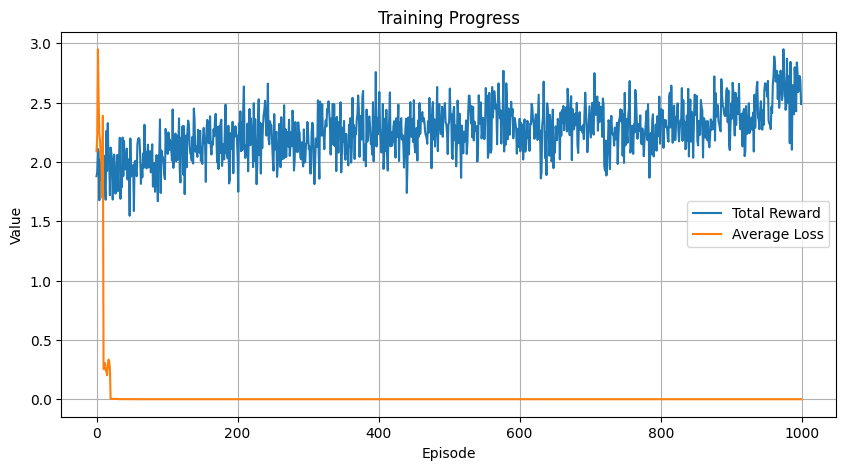

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label="Total Reward")
plt.plot(episode_losses, label="Average Loss")
plt.title("Training Progress")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


Final Portfolio Value: 1.32
Total Return: 31.58%
Sharpe Ratio: 0.71
Max Drawdown: -33.21%


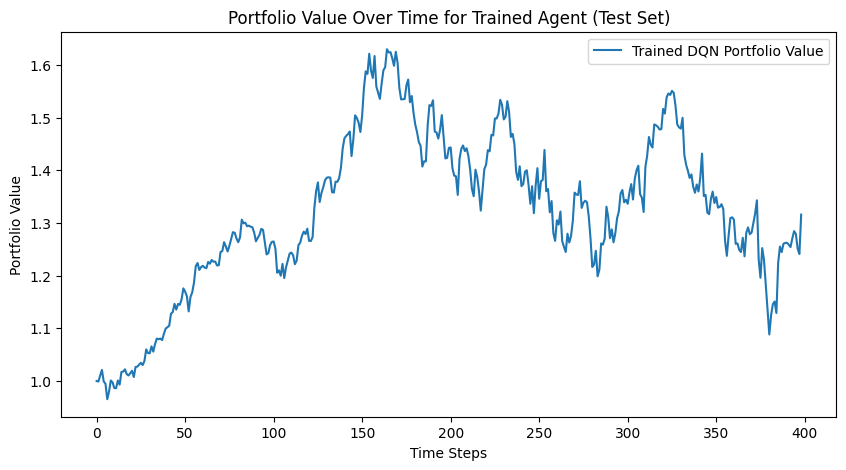

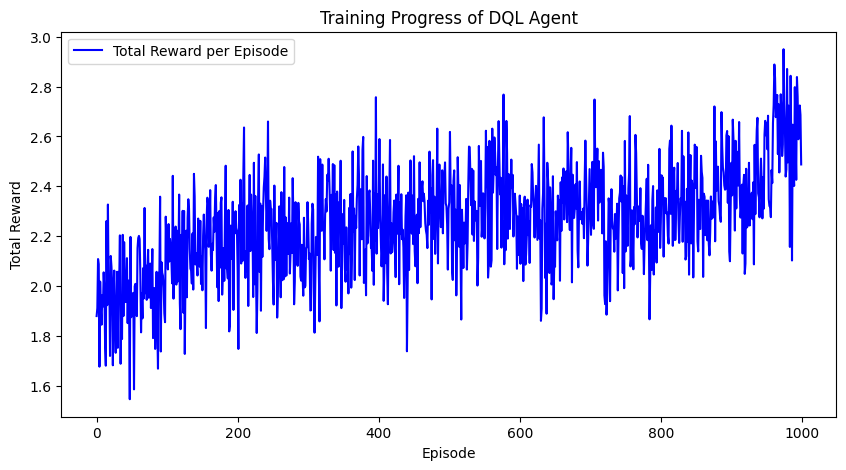

In [14]:

import numpy as np
import matplotlib.pyplot as plt
import torch

# Run the trained agent on test data (out-of-sample)
test_env = PortfolioEnv(feature_df=test_features, price_df=test_prices, action_space=action_space, reward_mode="growth")
state = test_env.reset()
done = False
portfolio_values = [test_env.portfolio_value]  # Track portfolio value over time

while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    q_vals = policy_net(state_tensor)
    action_idx = int(torch.argmax(q_vals, dim=1).item())  # Select best action

    next_state, reward, done = test_env.step(action_idx)  # Apply action in test environment
    state = next_state
    portfolio_values.append(test_env.portfolio_value)

# Convert portfolio values to returns
portfolio_values = np.array(portfolio_values)
portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]  # Compute daily returns

# Compute Sharpe Ratio (Annualized)
if np.std(portfolio_returns) > 0:
    sharpe_ratio = (np.mean(portfolio_returns) / np.std(portfolio_returns)) * np.sqrt(252)
else:
    sharpe_ratio = 0.0  # Avoid divide-by-zero errors

# Compute Maximum Drawdown
peak_values = np.maximum.accumulate(portfolio_values)  # Running max of portfolio
drawdowns = (portfolio_values - peak_values) / peak_values  # Drawdown percentage
max_drawdown = drawdowns.min()  # Worst drawdown

# Print Results
print(f"Final Portfolio Value: {portfolio_values[-1]:.2f}")
print(f"Total Return: {(portfolio_values[-1] / portfolio_values[0] - 1) * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")

# Plot Portfolio Value Over Time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_values, label="Trained DQN Portfolio Value")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time for Trained Agent (Test Set)")
plt.legend()
plt.show()

# Plot Training Progress (Total Reward Per Episode)
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label="Total Reward per Episode", color="blue")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress of DQL Agent")
plt.legend()
plt.show()



Performance Comparison:
DQN Agent - Final Value: 1.32, Sharpe: 0.71, Max Drawdown: -33.21%
Equal Weight - Final Value: 1.03, Sharpe: 0.22, Max Drawdown: -34.54%
Random Portfolio - Final Value: 1.11, Sharpe: 0.38, Max Drawdown: -30.46%


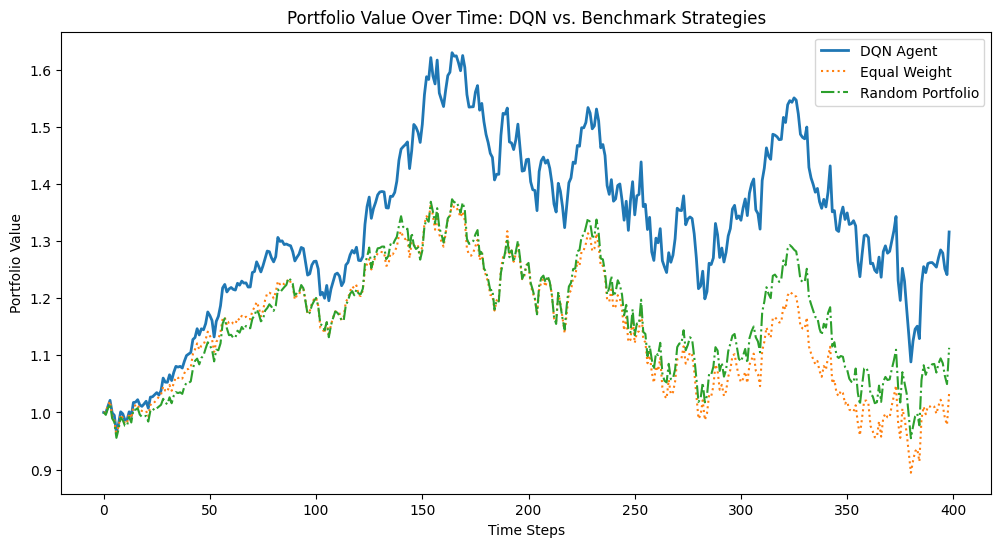

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize benchmarks
test_dates = test_env.dates  # Dates for the test period
num_assets = len(test_env.action_space[0])  # Number of assets

# Buy and Hold Strategy (keeps initial equal weights)
buy_hold_weights = np.array([1/num_assets] * num_assets)
buy_hold_values = [1.0]  # Start with portfolio value = 1

# Equal-weighted rebalanced strategy (rebalances every step)
equal_weight_values = [1.0]

# Random allocation strategy
random_values = [1.0]

# Run Benchmark Strategies
for i in range(len(test_dates) - 1):
    # Compute daily returns
    current_prices = test_env.price_df.iloc[i].values
    next_prices = test_env.price_df.iloc[i + 1].values
    asset_returns = (next_prices - current_prices) / current_prices

    # Buy-and-hold (keeps initial allocation)
    buy_hold_values.append(buy_hold_values[-1] * (1 + np.dot(buy_hold_weights, asset_returns)))

    # Equal-weighted (rebalanced each step)
    equal_weights = np.array([1/num_assets] * num_assets)
    equal_weight_values.append(equal_weight_values[-1] * (1 + np.dot(equal_weights, asset_returns)))

    # Random portfolio (new random allocation each step)
    random_weights = np.random.dirichlet(np.ones(num_assets))  # Ensures sum = 1
    random_values.append(random_values[-1] * (1 + np.dot(random_weights, asset_returns)))

# Convert portfolio values to arrays
buy_hold_values = np.array(buy_hold_values)
equal_weight_values = np.array(equal_weight_values)
random_values = np.array(random_values)

# Convert trained agent's portfolio values
dqn_values = np.array(portfolio_values)

# Compute key performance metrics (Sharpe Ratio & Max Drawdown)
def compute_metrics(portfolio_values):
    portfolio_returns = portfolio_values[1:] / portfolio_values[:-1] - 1
    sharpe_ratio = (np.mean(portfolio_returns) / np.std(portfolio_returns)) * np.sqrt(252) if np.std(portfolio_returns) > 0 else 0.0
    peak_values = np.maximum.accumulate(portfolio_values)
    max_drawdown = np.min((portfolio_values - peak_values) / peak_values)
    return portfolio_values[-1], sharpe_ratio, max_drawdown

# Get final results
dqn_final, dqn_sharpe, dqn_drawdown = compute_metrics(dqn_values)
buy_hold_final, buy_hold_sharpe, buy_hold_drawdown = compute_metrics(buy_hold_values)
equal_final, equal_sharpe, equal_drawdown = compute_metrics(equal_weight_values)
random_final, random_sharpe, random_drawdown = compute_metrics(random_values)

# Print Results
print("Performance Comparison:")
print(f"DQN Agent - Final Value: {dqn_final:.2f}, Sharpe: {dqn_sharpe:.2f}, Max Drawdown: {dqn_drawdown*100:.2f}%")
#print(f"Buy & Hold - Final Value: {buy_hold_final:.2f}, Sharpe: {buy_hold_sharpe:.2f}, Max Drawdown: {buy_hold_drawdown*100:.2f}%")
print(f"Equal Weight - Final Value: {equal_final:.2f}, Sharpe: {equal_sharpe:.2f}, Max Drawdown: {equal_drawdown*100:.2f}%")
print(f"Random Portfolio - Final Value: {random_final:.2f}, Sharpe: {random_sharpe:.2f}, Max Drawdown: {random_drawdown*100:.2f}%")

# Plot comparison of portfolio values
plt.figure(figsize=(12, 6))
plt.plot(dqn_values, label="DQN Agent", linewidth=2)
#plt.plot(buy_hold_values, label="Buy & Hold", linestyle="dashed")
plt.plot(equal_weight_values, label="Equal Weight", linestyle="dotted")
plt.plot(random_values, label="Random Portfolio", linestyle="dashdot")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time: DQN vs. Benchmark Strategies")
plt.legend()
plt.show()


Repeat the same training and testing for the other 2 objective functions.

Training:   0%|                                                                       | 1/1000 [00:02<40:11,  2.41s/it]

Episode 0, Total Reward: 2.12, Epsilon: 0.68


Training:  10%|██████▊                                                            | 101/1000 [10:22<1:35:08,  6.35s/it]

Episode 100, Total Reward: 1.75, Epsilon: 0.05


Training:  20%|█████████████▍                                                     | 201/1000 [20:55<1:23:21,  6.26s/it]

Episode 200, Total Reward: 1.76, Epsilon: 0.05


Training:  30%|████████████████████▏                                              | 301/1000 [31:29<1:14:07,  6.36s/it]

Episode 300, Total Reward: 1.53, Epsilon: 0.05


Training:  40%|██████████████████████████▊                                        | 401/1000 [42:27<1:05:39,  6.58s/it]

Episode 400, Total Reward: 1.84, Epsilon: 0.05


Training:  50%|██████████████████████████████████▌                                  | 501/1000 [53:22<51:08,  6.15s/it]

Episode 500, Total Reward: 1.85, Epsilon: 0.05


Training:  60%|████████████████████████████████████████▎                          | 601/1000 [1:04:06<43:13,  6.50s/it]

Episode 600, Total Reward: 2.14, Epsilon: 0.05


Training:  70%|██████████████████████████████████████████████▉                    | 701/1000 [1:14:40<31:37,  6.35s/it]

Episode 700, Total Reward: 2.52, Epsilon: 0.05


Training:  80%|█████████████████████████████████████████████████████▋             | 801/1000 [1:25:09<21:09,  6.38s/it]

Episode 800, Total Reward: 2.59, Epsilon: 0.05


Training:  90%|████████████████████████████████████████████████████████████▎      | 901/1000 [1:35:35<10:18,  6.25s/it]

Episode 900, Total Reward: 2.17, Epsilon: 0.05


Training: 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [1:46:01<00:00,  6.36s/it]


Training on train set complete.


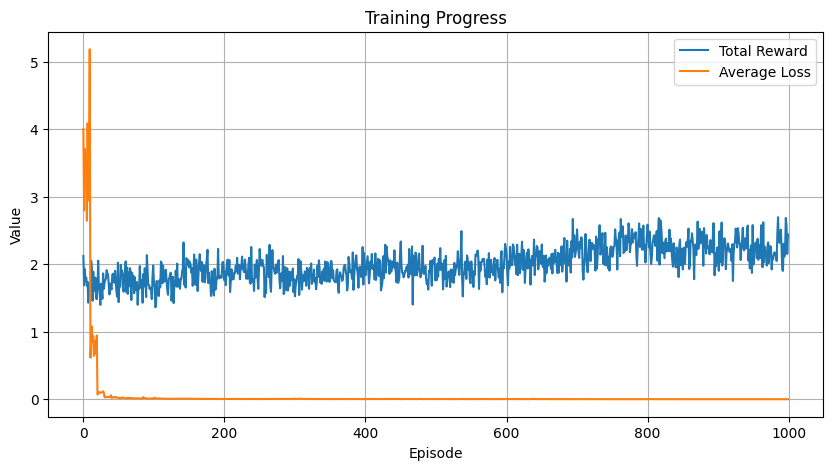

In [18]:
#Training for sharpe ratio objective function
# Hyperparameters
num_episodes = 1000
gamma = 0.99
batch_size = 64
lr = 1e-4
target_update_freq = 10
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_steps = 5000
warmup_steps = 1000
max_grad_norm = 1.0

# Setup
state_dim = train_features.shape[1]
action_dim = len(action_space)

policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
memory = ReplayBuffer(capacity=10000)

# Schedulers
step_count = 0
epsilon = epsilon_start

# Tracking
episode_rewards = []
episode_losses = []

for ep in trange(num_episodes, desc="Training"):
    state = train_env_sharp.reset()
    total_reward = 0
    losses = []

    done = False
    while not done:
        step_count += 1

        # Epsilon decay
        epsilon = max(epsilon_end, epsilon_start - step_count / epsilon_decay_steps)

        # Action selection
        if random.random() < epsilon:
            action_idx = random.randrange(action_dim)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                q_values = policy_net(state_tensor)
                action_idx = q_values.argmax().item()

        next_state, reward, done = train_env_sharp.step(action_idx)
        total_reward += reward

        memory.push(state, action_idx, reward, next_state if next_state is not None else state, done)
        state = next_state

        # Only train after warmup
        if len(memory) > warmup_steps:
            states_b, actions_b, rewards_b, next_states_b, dones_b = memory.sample(batch_size)

            # Q(s,a)
            q_values = policy_net(states_b).gather(1, actions_b.view(-1, 1)).squeeze(1)

            # Double DQN: a' = argmax Q(s', a; policy_net), Q_target = Q(s', a'; target_net)
            with torch.no_grad():
                next_actions = policy_net(next_states_b).argmax(1)
                next_q_values = target_net(next_states_b).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                target_q = rewards_b + gamma * next_q_values * (1 - dones_b)

            loss = F.smooth_l1_loss(q_values, target_q)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_grad_norm)
            optimizer.step()

            losses.append(loss.item())

    episode_rewards.append(total_reward)
    episode_losses.append(np.mean(losses) if losses else 0)

    if (ep + 1) % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())


    # Print training progress every 100 episodes
    if ep % 100 == 0:
        print(f"Episode {ep}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

print("Training on train set complete.")

plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label="Total Reward")
plt.plot(episode_losses, label="Average Loss")
plt.title("Training Progress")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Final Portfolio Value: 1.04
Total Return: 3.94%
Sharpe Ratio: 0.23
Max Drawdown: -36.92%


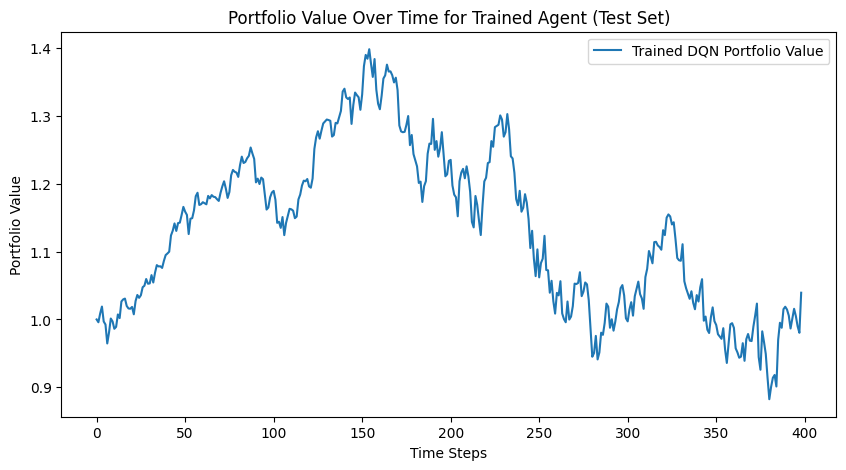

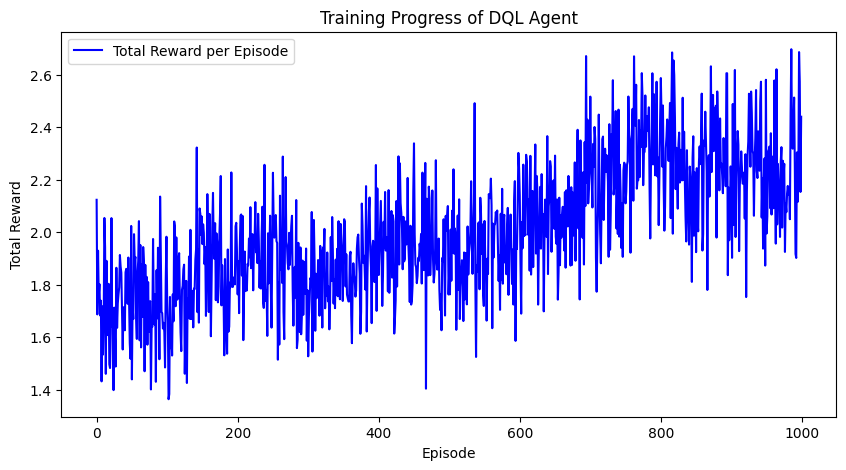

Performance Comparison:
DQN Agent - Final Value: 1.04, Sharpe: 0.23, Max Drawdown: -36.92%
Equal Weight - Final Value: 1.03, Sharpe: 0.22, Max Drawdown: -34.54%
Random Portfolio - Final Value: 1.06, Sharpe: 0.28, Max Drawdown: -33.49%


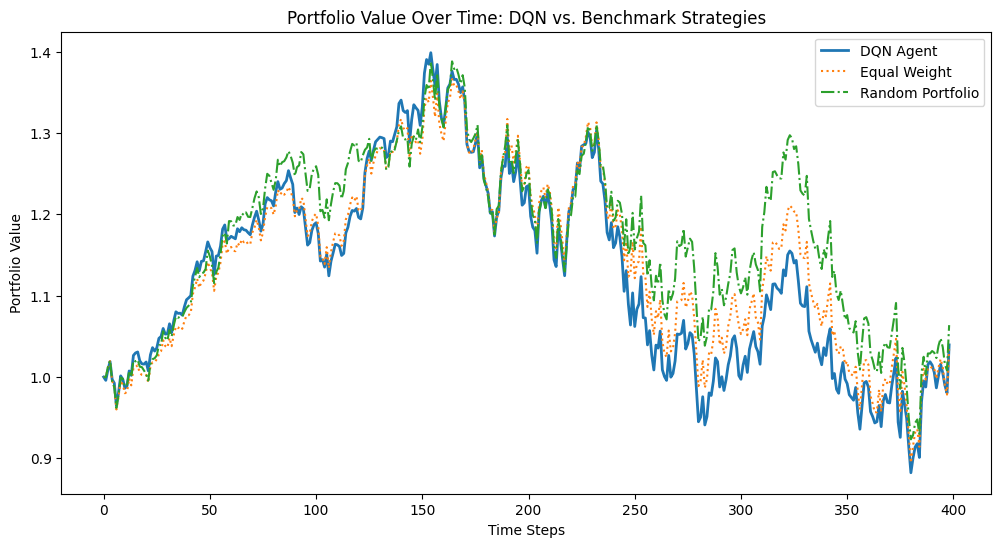

In [19]:
# Run the trained agent on test data (out-of-sample)
test_env = PortfolioEnv(feature_df=test_features, price_df=test_prices, action_space=action_space, reward_mode="sharpe")
state = test_env.reset()
done = False
portfolio_values = [test_env.portfolio_value]  # Track portfolio value over time

while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    q_vals = policy_net(state_tensor)
    action_idx = int(torch.argmax(q_vals, dim=1).item())  # Select best action

    next_state, reward, done = test_env.step(action_idx)  # Apply action in test environment
    state = next_state
    portfolio_values.append(test_env.portfolio_value)

# Convert portfolio values to returns
portfolio_values = np.array(portfolio_values)
portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]  # Compute daily returns

# Compute Sharpe Ratio (Annualized)
if np.std(portfolio_returns) > 0:
    sharpe_ratio = (np.mean(portfolio_returns) / np.std(portfolio_returns)) * np.sqrt(252)
else:
    sharpe_ratio = 0.0  # Avoid divide-by-zero errors

# Compute Maximum Drawdown
peak_values = np.maximum.accumulate(portfolio_values)  # Running max of portfolio
drawdowns = (portfolio_values - peak_values) / peak_values  # Drawdown percentage
max_drawdown = drawdowns.min()  # Worst drawdown

# Print Results
print(f"Final Portfolio Value: {portfolio_values[-1]:.2f}")
print(f"Total Return: {(portfolio_values[-1] / portfolio_values[0] - 1) * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")

# Plot Portfolio Value Over Time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_values, label="Trained DQN Portfolio Value")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time for Trained Agent (Test Set)")
plt.legend()
plt.show()

# Plot Training Progress (Total Reward Per Episode)
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label="Total Reward per Episode", color="blue")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress of DQL Agent")
plt.legend()
plt.show()

# Initialize benchmarks
test_dates = test_env.dates  # Dates for the test period
num_assets = len(test_env.action_space[0])  # Number of assets

# Buy and Hold Strategy (keeps initial equal weights)
buy_hold_weights = np.array([1/num_assets] * num_assets)
buy_hold_values = [1.0]  # Start with portfolio value = 1

# Equal-weighted rebalanced strategy (rebalances every step)
equal_weight_values = [1.0]

# Random allocation strategy
random_values = [1.0]

# Run Benchmark Strategies
for i in range(len(test_dates) - 1):
    # Compute daily returns
    current_prices = test_env.price_df.iloc[i].values
    next_prices = test_env.price_df.iloc[i + 1].values
    asset_returns = (next_prices - current_prices) / current_prices

    # Buy-and-hold (keeps initial allocation)
    buy_hold_values.append(buy_hold_values[-1] * (1 + np.dot(buy_hold_weights, asset_returns)))

    # Equal-weighted (rebalanced each step)
    equal_weights = np.array([1/num_assets] * num_assets)
    equal_weight_values.append(equal_weight_values[-1] * (1 + np.dot(equal_weights, asset_returns)))

    # Random portfolio (new random allocation each step)
    random_weights = np.random.dirichlet(np.ones(num_assets))  # Ensures sum = 1
    random_values.append(random_values[-1] * (1 + np.dot(random_weights, asset_returns)))

# Convert portfolio values to arrays
buy_hold_values = np.array(buy_hold_values)
equal_weight_values = np.array(equal_weight_values)
random_values = np.array(random_values)

# Convert trained agent's portfolio values
dqn_values = np.array(portfolio_values)

# Compute key performance metrics (Sharpe Ratio & Max Drawdown)
def compute_metrics(portfolio_values):
    portfolio_returns = portfolio_values[1:] / portfolio_values[:-1] - 1
    sharpe_ratio = (np.mean(portfolio_returns) / np.std(portfolio_returns)) * np.sqrt(252) if np.std(portfolio_returns) > 0 else 0.0
    peak_values = np.maximum.accumulate(portfolio_values)
    max_drawdown = np.min((portfolio_values - peak_values) / peak_values)
    return portfolio_values[-1], sharpe_ratio, max_drawdown

# Get final results
dqn_final, dqn_sharpe, dqn_drawdown = compute_metrics(dqn_values)
buy_hold_final, buy_hold_sharpe, buy_hold_drawdown = compute_metrics(buy_hold_values)
equal_final, equal_sharpe, equal_drawdown = compute_metrics(equal_weight_values)
random_final, random_sharpe, random_drawdown = compute_metrics(random_values)

# Print Results
print("Performance Comparison:")
print(f"DQN Agent - Final Value: {dqn_final:.2f}, Sharpe: {dqn_sharpe:.2f}, Max Drawdown: {dqn_drawdown*100:.2f}%")
#print(f"Buy & Hold - Final Value: {buy_hold_final:.2f}, Sharpe: {buy_hold_sharpe:.2f}, Max Drawdown: {buy_hold_drawdown*100:.2f}%")
print(f"Equal Weight - Final Value: {equal_final:.2f}, Sharpe: {equal_sharpe:.2f}, Max Drawdown: {equal_drawdown*100:.2f}%")
print(f"Random Portfolio - Final Value: {random_final:.2f}, Sharpe: {random_sharpe:.2f}, Max Drawdown: {random_drawdown*100:.2f}%")

# Plot comparison of portfolio values
plt.figure(figsize=(12, 6))
plt.plot(dqn_values, label="DQN Agent", linewidth=2)
#plt.plot(buy_hold_values, label="Buy & Hold", linestyle="dashed")
plt.plot(equal_weight_values, label="Equal Weight", linestyle="dotted")
plt.plot(random_values, label="Random Portfolio", linestyle="dashdot")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time: DQN vs. Benchmark Strategies")
plt.legend()
plt.show()

Training:   0%|                                                                       | 1/1000 [00:02<40:13,  2.42s/it]

Episode 0, Total Reward: -5.59, Epsilon: 0.68


Training:  10%|██████▊                                                            | 101/1000 [10:18<1:36:35,  6.45s/it]

Episode 100, Total Reward: -5.12, Epsilon: 0.05


Training:  20%|█████████████▍                                                     | 201/1000 [20:47<1:23:36,  6.28s/it]

Episode 200, Total Reward: -4.00, Epsilon: 0.05


Training:  30%|████████████████████▏                                              | 301/1000 [31:16<1:13:30,  6.31s/it]

Episode 300, Total Reward: -3.65, Epsilon: 0.05


Training:  40%|██████████████████████████▊                                        | 401/1000 [41:47<1:03:07,  6.32s/it]

Episode 400, Total Reward: -3.67, Epsilon: 0.05


Training:  50%|██████████████████████████████████▌                                  | 501/1000 [52:19<52:47,  6.35s/it]

Episode 500, Total Reward: -3.75, Epsilon: 0.05


Training:  60%|████████████████████████████████████████▎                          | 601/1000 [1:02:49<40:59,  6.16s/it]

Episode 600, Total Reward: -3.66, Epsilon: 0.05


Training:  70%|██████████████████████████████████████████████▉                    | 701/1000 [1:13:19<31:07,  6.24s/it]

Episode 700, Total Reward: -3.83, Epsilon: 0.05


Training:  80%|█████████████████████████████████████████████████████▋             | 801/1000 [1:23:51<21:03,  6.35s/it]

Episode 800, Total Reward: -4.06, Epsilon: 0.05


Training:  90%|████████████████████████████████████████████████████████████▎      | 901/1000 [1:34:23<10:24,  6.30s/it]

Episode 900, Total Reward: -3.38, Epsilon: 0.05


Training: 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [1:44:47<00:00,  6.29s/it]


Training on train set complete.


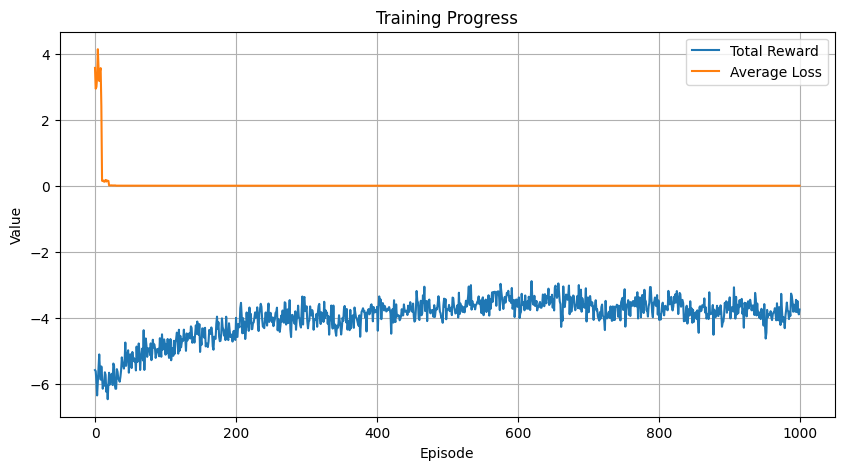

In [20]:
#Training for Drawdown objective
# Hyperparameters
num_episodes = 1000
gamma = 0.99
batch_size = 64
lr = 1e-4
target_update_freq = 10
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_steps = 5000
warmup_steps = 1000
max_grad_norm = 1.0

# Setup
state_dim = train_features.shape[1]
action_dim = len(action_space)

policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
memory = ReplayBuffer(capacity=10000)

# Schedulers
step_count = 0
epsilon = epsilon_start

# Tracking
episode_rewards = []
episode_losses = []

for ep in trange(num_episodes, desc="Training"):
    state = train_env_draw.reset()
    total_reward = 0
    losses = []

    done = False
    while not done:
        step_count += 1

        # Epsilon decay
        epsilon = max(epsilon_end, epsilon_start - step_count / epsilon_decay_steps)

        # Action selection
        if random.random() < epsilon:
            action_idx = random.randrange(action_dim)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                q_values = policy_net(state_tensor)
                action_idx = q_values.argmax().item()

        next_state, reward, done = train_env_draw.step(action_idx)
        total_reward += reward

        memory.push(state, action_idx, reward, next_state if next_state is not None else state, done)
        state = next_state

        # Only train after warmup
        if len(memory) > warmup_steps:
            states_b, actions_b, rewards_b, next_states_b, dones_b = memory.sample(batch_size)

            # Q(s,a)
            q_values = policy_net(states_b).gather(1, actions_b.view(-1, 1)).squeeze(1)

            # Double DQN: a' = argmax Q(s', a; policy_net), Q_target = Q(s', a'; target_net)
            with torch.no_grad():
                next_actions = policy_net(next_states_b).argmax(1)
                next_q_values = target_net(next_states_b).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                target_q = rewards_b + gamma * next_q_values * (1 - dones_b)

            loss = F.smooth_l1_loss(q_values, target_q)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_grad_norm)
            optimizer.step()

            losses.append(loss.item())

    episode_rewards.append(total_reward)
    episode_losses.append(np.mean(losses) if losses else 0)

    if (ep + 1) % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())


    # Print training progress every 10 episodes
    if ep % 100 == 0:
        print(f"Episode {ep}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

print("Training on train set complete.")

plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label="Total Reward")
plt.plot(episode_losses, label="Average Loss")
plt.title("Training Progress")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Final Portfolio Value: 0.98
Total Return: -1.76%
Sharpe Ratio: 0.12
Max Drawdown: -38.41%


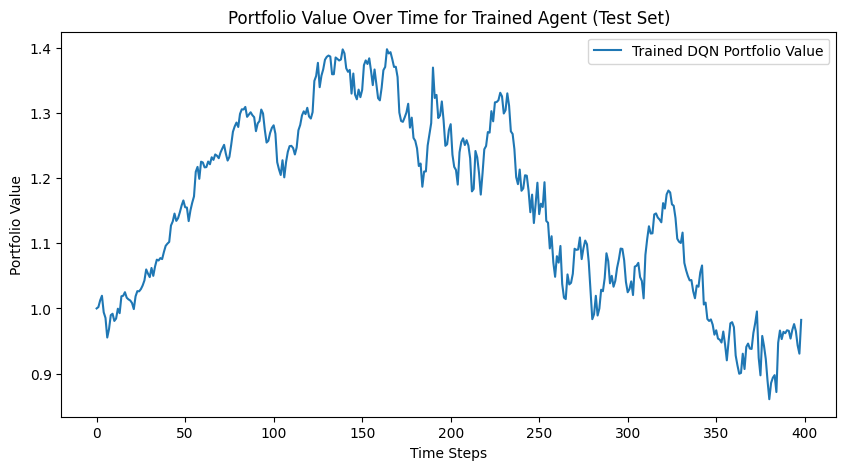

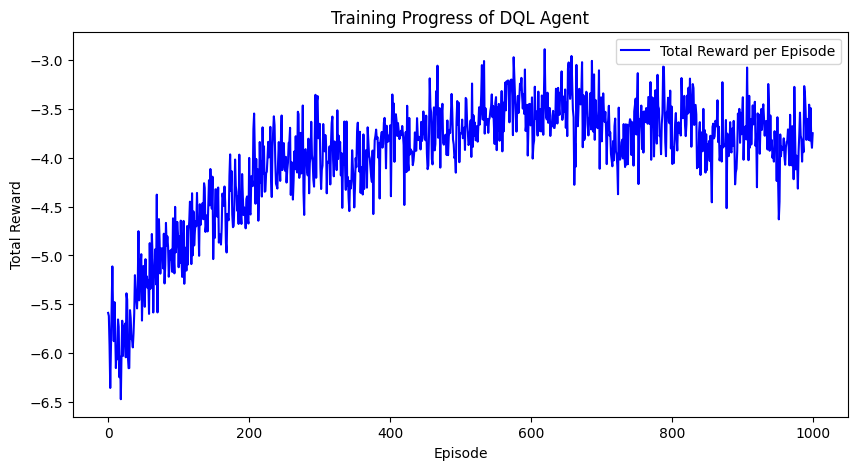

Performance Comparison:
DQN Agent - Final Value: 0.98, Sharpe: 0.12, Max Drawdown: -38.41%
Equal Weight - Final Value: 1.03, Sharpe: 0.22, Max Drawdown: -34.54%
Random Portfolio - Final Value: 0.98, Sharpe: 0.10, Max Drawdown: -35.82%


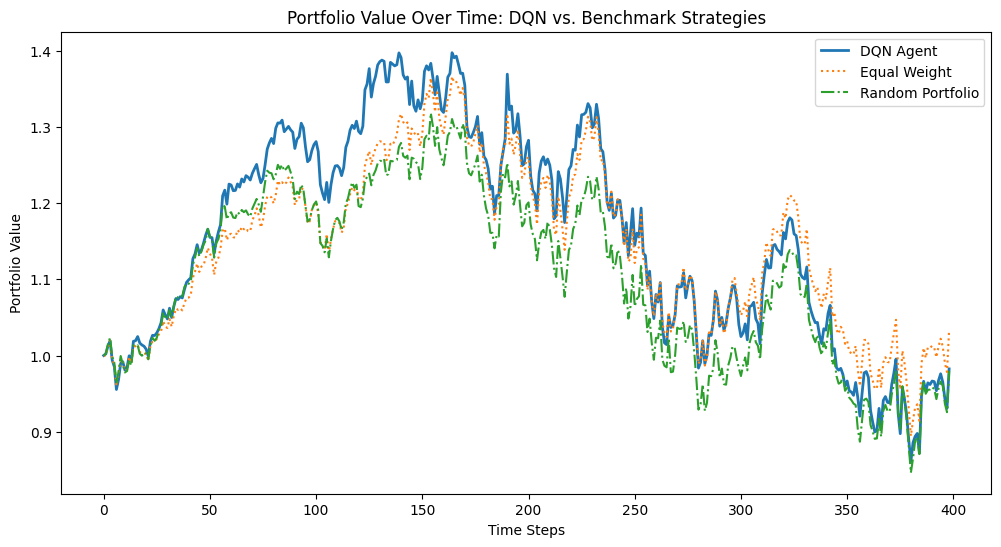

In [21]:
# Run the trained agent on test data (out-of-sample)
test_env = PortfolioEnv(feature_df=test_features, price_df=test_prices, action_space=action_space, reward_mode="drawdown")
state = test_env.reset()
done = False
portfolio_values = [test_env.portfolio_value]  # Track portfolio value over time

while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    q_vals = policy_net(state_tensor)
    action_idx = int(torch.argmax(q_vals, dim=1).item())  # Select best action

    next_state, reward, done = test_env.step(action_idx)  # Apply action in test environment
    state = next_state
    portfolio_values.append(test_env.portfolio_value)

# Convert portfolio values to returns
portfolio_values = np.array(portfolio_values)
portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]  # Compute daily returns

# Compute Sharpe Ratio (Annualized)
if np.std(portfolio_returns) > 0:
    sharpe_ratio = (np.mean(portfolio_returns) / np.std(portfolio_returns)) * np.sqrt(252)
else:
    sharpe_ratio = 0.0  # Avoid divide-by-zero errors

# Compute Maximum Drawdown
peak_values = np.maximum.accumulate(portfolio_values)  # Running max of portfolio
drawdowns = (portfolio_values - peak_values) / peak_values  # Drawdown percentage
max_drawdown = drawdowns.min()  # Worst drawdown

# Print Results
print(f"Final Portfolio Value: {portfolio_values[-1]:.2f}")
print(f"Total Return: {(portfolio_values[-1] / portfolio_values[0] - 1) * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")

# Plot Portfolio Value Over Time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_values, label="Trained DQN Portfolio Value")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time for Trained Agent (Test Set)")
plt.legend()
plt.show()

# Plot Training Progress (Total Reward Per Episode)
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label="Total Reward per Episode", color="blue")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress of DQL Agent")
plt.legend()
plt.show()

# Initialize benchmarks
test_dates = test_env.dates  # Dates for the test period
num_assets = len(test_env.action_space[0])  # Number of assets

# Buy and Hold Strategy (keeps initial equal weights)
buy_hold_weights = np.array([1/num_assets] * num_assets)
buy_hold_values = [1.0]  # Start with portfolio value = 1

# Equal-weighted rebalanced strategy (rebalances every step)
equal_weight_values = [1.0]

# Random allocation strategy
random_values = [1.0]

# Run Benchmark Strategies
for i in range(len(test_dates) - 1):
    # Compute daily returns
    current_prices = test_env.price_df.iloc[i].values
    next_prices = test_env.price_df.iloc[i + 1].values
    asset_returns = (next_prices - current_prices) / current_prices

    # Buy-and-hold (keeps initial allocation)
    buy_hold_values.append(buy_hold_values[-1] * (1 + np.dot(buy_hold_weights, asset_returns)))

    # Equal-weighted (rebalanced each step)
    equal_weights = np.array([1/num_assets] * num_assets)
    equal_weight_values.append(equal_weight_values[-1] * (1 + np.dot(equal_weights, asset_returns)))

    # Random portfolio (new random allocation each step)
    random_weights = np.random.dirichlet(np.ones(num_assets))  # Ensures sum = 1
    random_values.append(random_values[-1] * (1 + np.dot(random_weights, asset_returns)))

# Convert portfolio values to arrays
buy_hold_values = np.array(buy_hold_values)
equal_weight_values = np.array(equal_weight_values)
random_values = np.array(random_values)

# Convert trained agent's portfolio values
dqn_values = np.array(portfolio_values)

# Compute key performance metrics (Sharpe Ratio & Max Drawdown)
def compute_metrics(portfolio_values):
    portfolio_returns = portfolio_values[1:] / portfolio_values[:-1] - 1
    sharpe_ratio = (np.mean(portfolio_returns) / np.std(portfolio_returns)) * np.sqrt(252) if np.std(portfolio_returns) > 0 else 0.0
    peak_values = np.maximum.accumulate(portfolio_values)
    max_drawdown = np.min((portfolio_values - peak_values) / peak_values)
    return portfolio_values[-1], sharpe_ratio, max_drawdown

# Get final results
dqn_final, dqn_sharpe, dqn_drawdown = compute_metrics(dqn_values)
buy_hold_final, buy_hold_sharpe, buy_hold_drawdown = compute_metrics(buy_hold_values)
equal_final, equal_sharpe, equal_drawdown = compute_metrics(equal_weight_values)
random_final, random_sharpe, random_drawdown = compute_metrics(random_values)

# Print Results
print("Performance Comparison:")
print(f"DQN Agent - Final Value: {dqn_final:.2f}, Sharpe: {dqn_sharpe:.2f}, Max Drawdown: {dqn_drawdown*100:.2f}%")
#print(f"Buy & Hold - Final Value: {buy_hold_final:.2f}, Sharpe: {buy_hold_sharpe:.2f}, Max Drawdown: {buy_hold_drawdown*100:.2f}%")
print(f"Equal Weight - Final Value: {equal_final:.2f}, Sharpe: {equal_sharpe:.2f}, Max Drawdown: {equal_drawdown*100:.2f}%")
print(f"Random Portfolio - Final Value: {random_final:.2f}, Sharpe: {random_sharpe:.2f}, Max Drawdown: {random_drawdown*100:.2f}%")

# Plot comparison of portfolio values
plt.figure(figsize=(12, 6))
plt.plot(dqn_values, label="DQN Agent", linewidth=2)
#plt.plot(buy_hold_values, label="Buy & Hold", linestyle="dashed")
plt.plot(equal_weight_values, label="Equal Weight", linestyle="dotted")
plt.plot(random_values, label="Random Portfolio", linestyle="dashdot")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time: DQN vs. Benchmark Strategies")
plt.legend()
plt.show()

## 6. Evaluation  
We evaluate trained agents on test data and compare their:

- **Final Portfolio Value**
- **Total Return**
- **Sharpe Ratio**
- **Maximum Drawdown**

We compare different reward-based agents and a baseline equal-weight strategy. Expected results:

| Strategy            | Final Value |
|---------------------|------------:|
| DQN (Return Reward) |    1.32    |          
| DQN (Sharpe Reward) |   1.04     |          
| DQN (Drawdown Reward)|     0.98  |       
| Equal-Weight Baseline|  1.03     | 

Based on the result the agents with portfiolio return and sharpe proxy are a little better than the equal weight portfolio. In the case of sharpe ratio and drawdown the agents are not performing that well, and there can be improvements done in the training as well as better selection of the reward functions. 

